In [1]:
''' basic libs '''
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import warnings

''' network '''
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam

''' onde hot ecoding'''
from keras.utils import to_categorical

''' curva ROC '''
from sklearn.metrics import roc_curve, auc

''' configure  '''
%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

print(os.listdir("../input"))

Using TensorFlow backend.


['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
%time df = pd.read_csv('../input/train.csv')
df.head()

CPU times: user 13.7 s, sys: 4.07 s, total: 17.8 s
Wall time: 17.8 s


,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

In [3]:
df.describe()

,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,flaky-goldenrod-bat-noise,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
count,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,...,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000
mean,0.005924,0.000936,-0.012530,-0.005688,0.001607,0.007878,-0.003500,-0.005927,0.002664,0.020485,-0.001629,0.008115,-0.001445,0.006434,0.013150,-0.016462,0.014498,0.000990,-0.004702,-0.010490,0.006592,-0.007705,0.010857,-0.011858,-0.005172,-0.012855,-0.003606,0.001209,0.007980,-0.005911,-0.000397,-0.000490,-0.013010,-0.000040,0.003882,-0.008507,-0.009352,0.007037,0.004091,-0.011576,...,-0.002381,-0.010963,0.005069,0.001779,0.011217,-0.000718,-0.008141,0.003521,0.011593,-0.011187,0.001626,0.000656,0

## Treinamento
### Codificar os dados para o formato de treinamento
 - verificar as proriedades estatísticas dos dados.
 - features: dados entre -1 e 1
 - target: 0 e 1 [usar hot enconding]

### Selecionar os dados $X$ e $Y$.

In [4]:
''' select features ans labels '''
features = df.ix[:,1:257]
labels = df.ix[:,257]

In [5]:
print('SHAPE -> Features :',features.shape ,'Labels :',labels.shape, 'df Rows :', len(df), 'df Columms :', len(df.columns))

SHAPE -> Features : (262144, 256) Labels : (262144,) df Rows : 262144 df Columms : 258


## Transformar os dados em tensores.

In [6]:
''' selecionado uma amostra '''

size = 262144

''' convert data in tensor '''
x = np.array(features.ix[:size,:])
y = np.array(labels.ix[:size])

''' tranform data in float '''
x = x.astype('float')

''' normalize your data '''
x -= x.mean(axis=0)
x /= x.std(axis=0)

''' one hot encoding '''
y = to_categorical(y)

print(x.shape, y.shape)

(262144, 256) (262144, 2)


## Split data in : train, test and validation

In [7]:
def proportion_split(total, verbose=False):
    p_train = int(total/2)
    p_test  = int(p_train/2)
    p_lim_test = (p_train+p_test)
    if verbose:
        print('Train(:%i) Test(%i:%i) Validation(:%i)' %(p_train,p_train,p_lim_test,p_lim_test))
        print('-'*30)
        return p_train, p_lim_test
    else:
        return p_train, p_lim_test

ini, end = proportion_split(size, verbose=True)

x_train = x[:ini,]
x_test = x[ini:end,]
x_val = x[end:,]

y_train = y[:ini,]
y_test = y[ini:end,]
y_val = y[end:,]

print('x_train'+str(x_train.shape)+' y_train'+str(y_train.shape)+
      ' | x_test'+str(x_test.shape)+' y_test'+str(y_test.shape)+
      ' | x_val'+str(x_val.shape)+' y_val'+str(y_val.shape))


Train(:131072) Test(131072:196608) Validation(:196608)
------------------------------
x_train(131072, 256) y_train(131072, 2) | x_test(65536, 256) y_test(65536, 2) | x_val(65536, 256) y_val(65536, 2)


### Parameters

In [9]:
num_classes = 2
epocas = 20
lote = 32
taxa_aprendizado = 0.001

## Model

In [19]:
def NeuralNetwork(entrada):
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(entrada,)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [20]:
nn = NeuralNetwork(x.shape[1])

In [21]:
%time hist = nn.fit(x_train,y_train, epochs=20, validation_data=(x_val, y_val), verbose=0)

CPU times: user 5min 24s, sys: 1min 35s, total: 6min 59s
Wall time: 3min 43s


In [22]:
def print_score(metricas, evaluation):
    print('_'*20)
    print('Model Evaluate')
    print('-'*20)
    for i in range(len(evaluation)):
        print(metricas[i]+' = %.2f' %(evaluation[i]))
    print('-'*20)
        
def plot_log_train(log):
    chaves = list(log.keys())
    print(chaves)
    plt.figure(figsize=(15,6))
    for i in range(len(chaves)):
        plt.plot(log[chaves[i]], '-o', label=chaves[i])
    plt.legend()
    plt.show()
    
def plots_log_train(log):
    chaves = list(log.keys())
    fig = plt.figure(figsize=(18,5))
    
    ax = fig.add_subplot(121)
    ax.plot(log[chaves[0]], '-o', label=chaves[0])
    ax.plot(log[chaves[2]], '-o', label=chaves[2])
    ax.set_title('Loss')
    ax.legend()
    
    ax = fig.add_subplot(122)
    ax.set_title('Accuracy')
    ax.plot(log[chaves[1]], '-o', label=chaves[1])
    ax.plot(log[chaves[3]], '-o', label=chaves[3])
    ax.legend()
    
    plt.show()

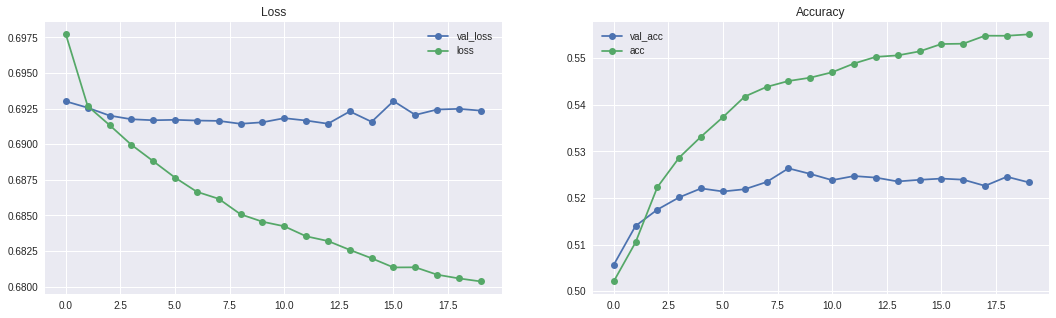

65536/65536 [==============================] - 2s 33us/step
____________________
Model Evaluate
--------------------
loss = 0.69
acc = 0.52
--------------------


In [23]:
plots_log_train(hist.history)
res = nn.evaluate(x_test, y_test)
print_score(nn.metrics_names, res)

In [24]:
y_pred = nn.predict(x_test)

In [25]:
fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
auc = auc(fpr, tpr)

TypeError: 'numpy.float64' object is not callable

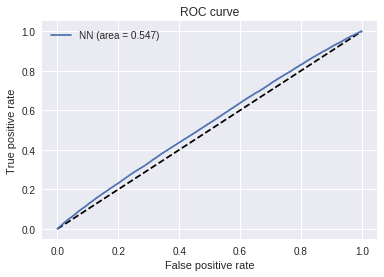

In [26]:
''' plot Curve ROC '''
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='NN (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()